In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score
import json
import csv
import re
from collections import namedtuple
import json


import warnings
warnings.filterwarnings("ignore")

In [3]:
N_WAVELENGTH = 228
LOD_URE = 1000

In [4]:
df = pd.read_csv("data_NIRS/Merged_db.csv")
df = df.drop_duplicates()
df_copy = df.copy()
df.head()

,Mã NIR,Urea,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,STT mẫu cá,Vị trí đo,Lần lặp,Phương pháp đo,...,230,231,232,233,234,235,236,237,238,239
0,2113099a1,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",1,Hadamard 1,...,-0.136101,-0.287185,-0.380416,-0.459176,-0.407652,-0.472400,-0.429911,-0.333819,-0.395731,-0.167501
1,2113099a2,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",2,Hadamard 1,...,-0.135012,-0.306666,-0.467668,-0.492477,-0.481871,-0.370628,-0.297349,-0.409274,-0.486664,-0.426964
2,2113099a3,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",3,Hadamard 1,...,-0.324308,-0.427586,-0.539696,-0.547557,-0.575114,-0.555003,-0.462344,-0.440240,-0.298107,-0.313747
3,2113099a4,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",4,Hadamard 1,...,-0.298622,-0.377505,-0.534373,-0.577949,-0.533663,-0.570596,-0.488621,-0.419825,-0.354021,-0.295377
4,2113099a5,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",5,Hadamard 1,...,-0.272732,-0.429970,-0.496265,-0.559068,-0.586745,-0.516311,-0.469121,-0.351306,-0.360435,-0.257529


In [5]:
for type in df['Loại cá'].unique():
    sub_df = df[df['Loại cá'] == type]
    sub_labels = np.where(sub_df['Urea'] >= LOD_URE, 1, 0)
    print(type, len(sub_df['STT mẫu cá'].value_counts()), np.unique(sub_labels, return_counts=True))

Nục 1 6 (array([1]), array([360], dtype=int64))
Nục 2 57 (array([0, 1]), array([2405, 1020], dtype=int64))
Ngừ 1 52 (array([0, 1]), array([2760,  360], dtype=int64))
Thu 1 26 (array([0, 1]), array([1185,  360], dtype=int64))


# Xử lý dữ liệu NaN và vô hạn

In [6]:
print(f'Tổng các điểm dữ liệu trống trước xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn trước xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống trước xử lý: 0
Tổng các điểm dữ liệu vô hạn trước xử lý: 0


In [7]:
# Lấy tất cả vị trí của các trị trống hoặc vô hạn
null_check = df.isna()
indices_null = np.argwhere(null_check.to_numpy() == True)

df_inf = df.iloc[:,-N_WAVELENGTH:]
inf_check = np.isinf(df_inf)
indices_inf = np.argwhere(inf_check.to_numpy()== True)
indices_inf[:,1] += df.shape[1] - N_WAVELENGTH

indices = np.concatenate((indices_inf, indices_null))

In [8]:
n_nearest = 2 # Sử dụng n giá trị gần nhất cả 2 phía trước và sau để tính mean của missing data
for x,y in indices:
    if y < df.shape[1] - N_WAVELENGTH: # Chỉ xử lý các missing data của phổ
        continue
    #sample = df.iloc[x, np.maximum(y - n_nearest , 0):np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    left = df.iloc[x,  np.maximum(y - n_nearest , 0) : y]
    right = df.iloc[x, y + 1 : np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    sample = left.combine_first(right)
    df.iloc[x, y] = np.mean(sample)


In [9]:
print(f'Tổng các điểm dữ liệu trống sau xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn sau xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0


# Sửa các mã NIR bị lỗi 
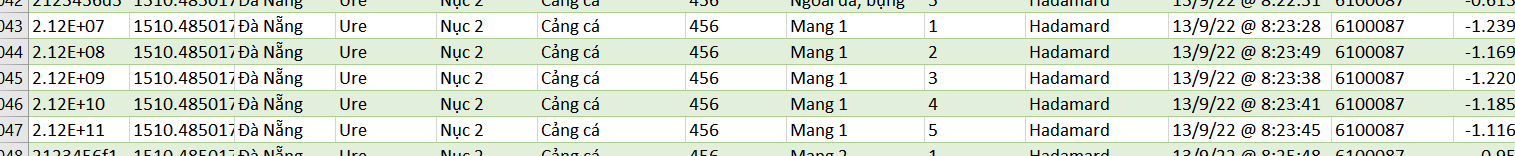

In [10]:

configJsonLink = 'config.json'
config = json.load(open(configJsonLink, encoding="utf8"))
config = namedtuple("ObjectName", config.keys())(*config.values())

nirsMetadataCoding = json.load(open(config.nirsMetadataCodingFileName, encoding="utf8"))
nirsMetadataCoding = namedtuple("ObjectName", nirsMetadataCoding.keys())(*nirsMetadataCoding.values())

In [11]:
count = 0
for i in df.index:
    nir_code = df['Mã NIR'][i]
    if not bool(re.search(r'[a-z]',nir_code)):
        nir_code_fixed = ''
        for nirsIdComponent in config.nirsIdComponents:
            nirsMetadata = [data for data in nirsMetadataCoding.nirsIdComponents if data['name'] == nirsIdComponent['name']][0]
            
            for value in nirsMetadata['decode']:
                name = nirsIdComponent['name']
                if (df[name][i] == value['name']):
                    if name == 'STT mẫu cá':
                        nir_code_fixed += str(value['key']).zfill(3)
                    else:
                        nir_code_fixed += str(value['key'])
                        
        print(f'{i} : {nir_code} ==> {nir_code_fixed}')
        df['Mã NIR'][i] = nir_code_fixed
        count +=1
        
print('samples replaced: ', count)

20 : 2.11E+07 ==> 2113099er1
21 : 2.11E+08 ==> 2113099er2
22 : 2.11E+09 ==> 2113099er3
23 : 2.11E+10 ==> 2113099er4
24 : 2.11E+11 ==> 2113099er5
80 : 2.11E+07 ==> 2113100er1
81 : 2.11E+08 ==> 2113100er2
82 : 2.11E+09 ==> 2113100er3
83 : 2.11E+10 ==> 2113100er4
84 : 2.11E+11 ==> 2113100er5
140 : 2.11E+07 ==> 2113101er1
141 : 2.11E+08 ==> 2113101er2
142 : 2.11E+09 ==> 2113101er3
143 : 2.11E+10 ==> 2113101er4
144 : 2.11E+11 ==> 2113101er5
200 : 2.11E+07 ==> 2113113er1
201 : 2.11E+08 ==> 2113113er2
202 : 2.11E+09 ==> 2113113er3
203 : 2.11E+10 ==> 2113113er4
204 : 2.11E+11 ==> 2113113er5
260 : 2.11E+07 ==> 2113114er1
261 : 2.11E+08 ==> 2113114er2
262 : 2.11E+09 ==> 2113114er3
263 : 2.11E+10 ==> 2113114er4
264 : 2.11E+11 ==> 2113114er5
320 : 2.11E+07 ==> 2113115er1
321 : 2.11E+08 ==> 2113115er2
322 : 2.11E+09 ==> 2113115er3
323 : 2.11E+10 ==> 2113115er4
324 : 2.11E+11 ==> 2113115er5
380 : 2.12E+07 ==> 2123188er1
381 : 2.12E+08 ==> 2123188er2
382 : 2.12E+09 ==> 2123188er3
383 : 2.12E+10 ==> 2

# Chọn các trưng tối ưu nhất cho bài toán (chọn trước khi xử lý dữ liệu)

In [12]:
# from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
# top_n_features = 30

# y = np.where(df['Urea'] > LOD_URE, 1, 0)

# best_features = SelectKBest(score_func=f_classif, k=top_n_features)
# fit = best_features.fit(df.iloc[:,-N_WAVELENGTH:], y)
# df_scores = pd.DataFrame(fit.scores_)
# df_columns = pd.DataFrame(df.iloc[:,-N_WAVELENGTH:].columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([df_columns, df_scores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# optimal_wavelengths = list(fit.get_feature_names_out())
# print(featureScores.nlargest(top_n_features,'Score'))
# sorted(optimal_wavelengths)

# Tạo test data từ dữ liệu gốc, tất cả các mẫu NIR của 1 con cá (thường là 60) thì sẽ nằm trong test data

In [13]:
TEST_SIZE = 0.2

fish_numbers = df['STT mẫu cá'].unique()

ure_value = []
for number in fish_numbers:
    sub_df = df[df['STT mẫu cá'] == number]
    # print(stt, sub_df['Urea'].value_counts())
    ure_value.append(sub_df['Urea'].iloc[1])
y_labels = np.where(np.array(ure_value) >= LOD_URE, 1, 0)

number_test_fish = int(len(fish_numbers)*TEST_SIZE)

indices_below_LOD = np.where(y_labels == 0)[0]
test_indices_below_LOD = np.random.choice(indices_below_LOD, size=number_test_fish//2, replace=False)
test_fish_numbers_below_LOD = fish_numbers[test_indices_below_LOD]

indices_above_LOD = np.where(y_labels == 1)[0]
test_indices_above_LOD = np.random.choice(indices_above_LOD, size=number_test_fish//2, replace=False)
test_fish_numbers_above_LOD = fish_numbers[test_indices_above_LOD]

test_fish_number = np.hstack((test_fish_numbers_above_LOD, test_fish_numbers_below_LOD))

test_data = pd.DataFrame()
train_data = df.copy()
for i in test_fish_number:
    sub_df = df[df['STT mẫu cá'] == i]
    test_data = pd.concat([test_data, sub_df], axis=0)
    
    train_data = train_data.drop(train_data[train_data['STT mẫu cá'] == i].index)

In [89]:
test_data.to_csv('train_data_Ure.csv', encoding='utf-8', index=False)
test_data.to_csv('test_data_Ure.csv', encoding='utf-8', index=False)

In [91]:
test_fish = [465, 115, 263, 565, 466, 467, 563, 205, 204, 194, 464, 101,  99,
114, 544, 555, 190, 448, 477, 473, 543, 487, 552, 469, 385, 255,388, 381]

# Chia dữ liệu Train và trực quan trước khi SMOTE

In [14]:
X_TRAIN = train_data.iloc[:,-N_WAVELENGTH:]
Y_TRAIN = np.where(train_data['Urea'] >= LOD_URE, 1, 0)

Xử lý dữ liệu imbalance với SMOTE

Text(0.5, 1.0, 'Label Percentage(%) after SMOTE')

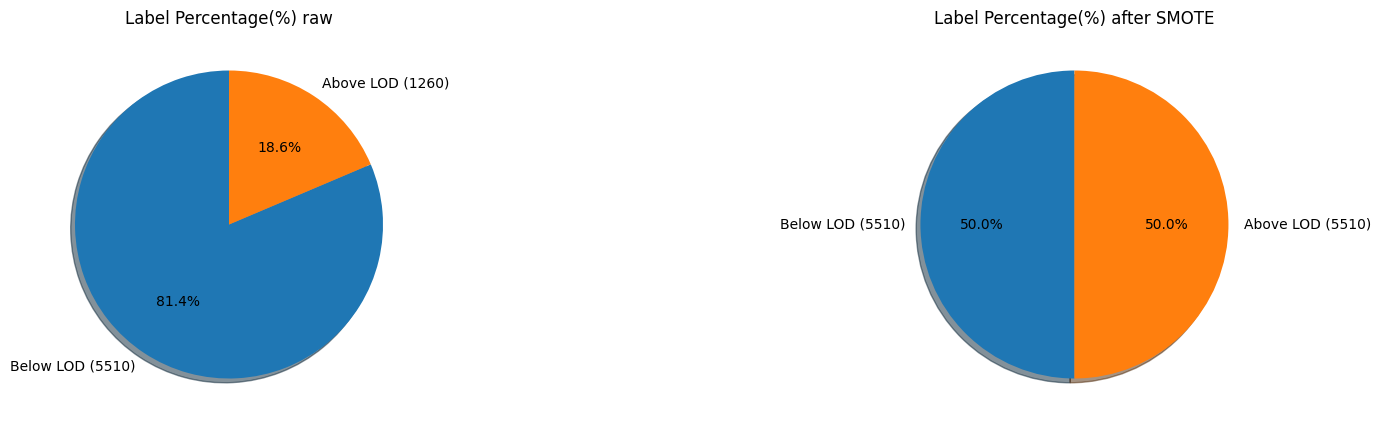

In [15]:
from imblearn.over_sampling import SMOTE
over_sample = SMOTE()
X_TRAIN_SMOTE, Y_TRAIN_SMOTE = over_sample.fit_resample(X_TRAIN, Y_TRAIN)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

y_train_smote = np.unique(Y_TRAIN_SMOTE, return_counts = True)
y_train_raw = np.unique(Y_TRAIN, return_counts = True)

axes[0].pie(y_train_raw[1], labels=[f'Below LOD ({y_train_raw[1][0]})', f'Above LOD ({y_train_raw[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Label Percentage(%) raw')

axes[1].pie(y_train_smote[1], labels=[f'Below LOD ({y_train_smote[1][0]})', f'Above LOD ({y_train_smote[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%) after SMOTE')

Text(0.5, 1.0, 'Spectra NIR after SMOTE')

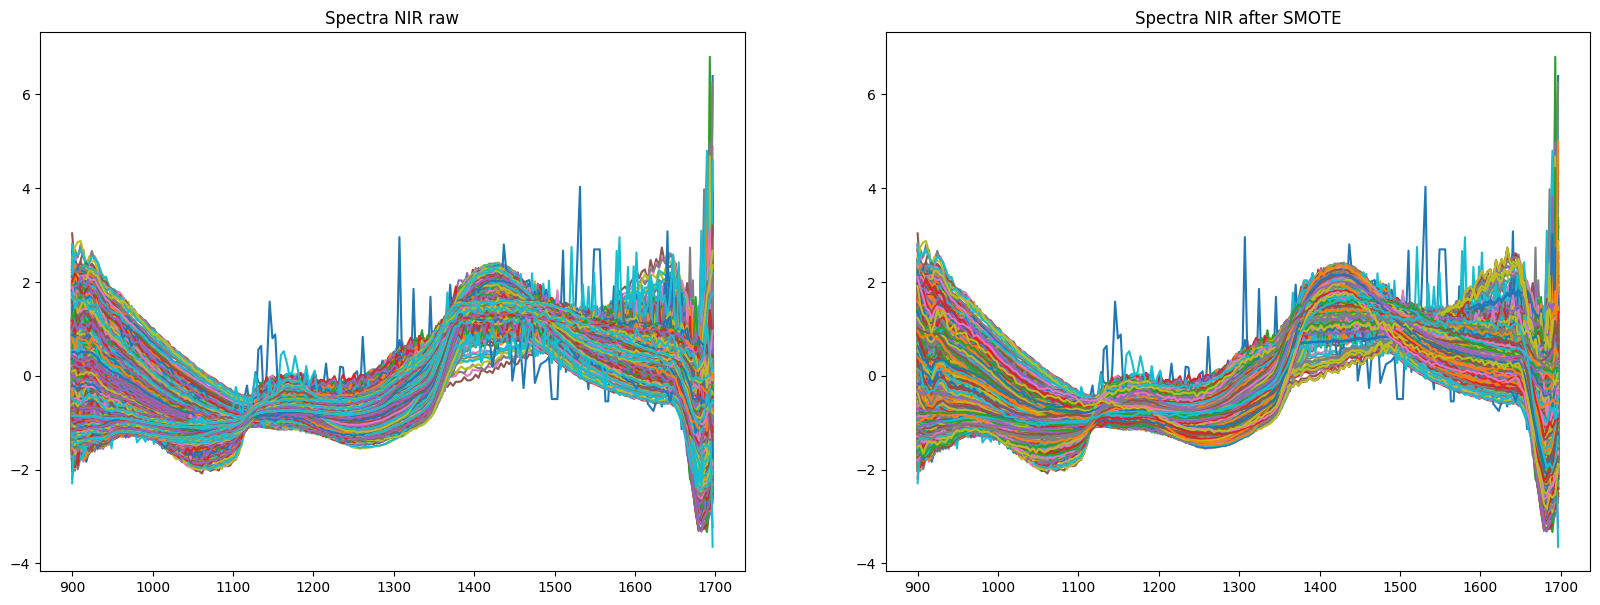

In [16]:
wl = np.arange(900, 1700, 800/228)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,7))
for i in range(X_TRAIN.shape[0]):
    axes[0].plot(wl, X_TRAIN.iloc[i,:])
axes[0].set_title('Spectra NIR raw')

for i in range(X_TRAIN_SMOTE.shape[0]):
    axes[1].plot(wl, X_TRAIN_SMOTE.iloc[i,:])
axes[1].set_title('Spectra NIR after SMOTE')


Chia dữ liệu TEST (không dùng SMOTE)

Text(0.5, 1.0, 'Count of label')

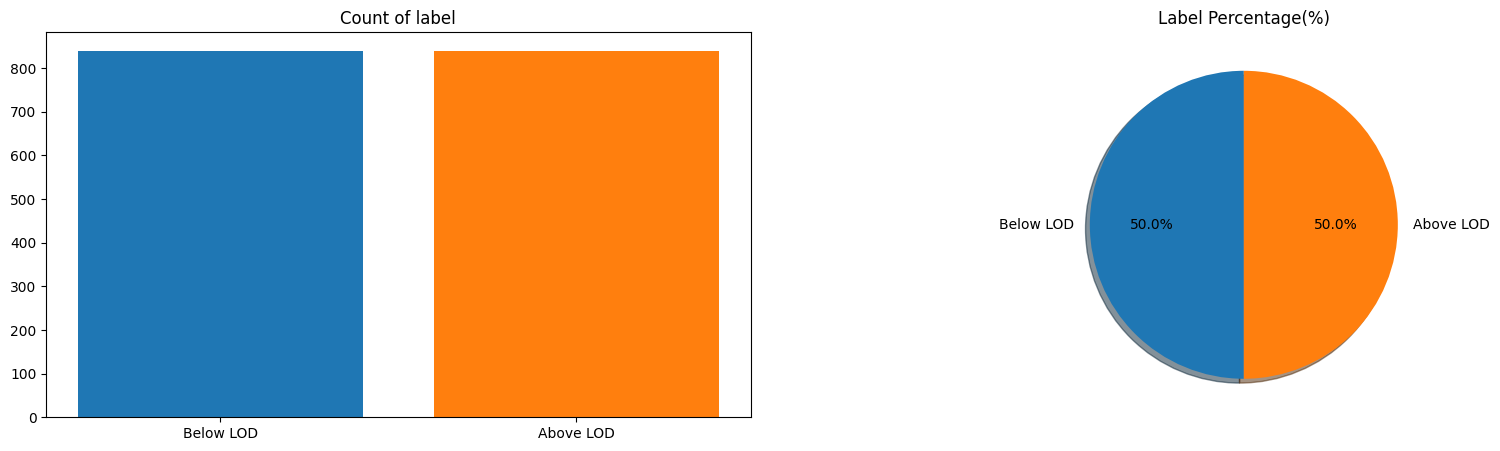

In [17]:
X_TEST = test_data.iloc[:,-N_WAVELENGTH:]
Y_TEST = np.where(test_data['Urea'] >= LOD_URE, 1, 0)
y_test_raw = np.unique(Y_TEST, return_counts = True)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

axes[1].pie(y_test_raw[1], labels=['Below LOD', 'Above LOD'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%)')
axes[0].bar(y_test_raw[0], y_test_raw[1], tick_label=['Below LOD', 'Above LOD'], align='center', color=sns.color_palette())
axes[0].set_title('Count of label')

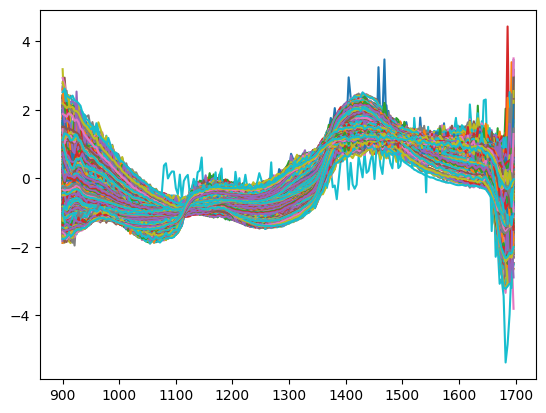

In [18]:
wl = np.arange(900, 1700, 800/228)
for i in range(X_TEST.shape[0]):
    plt.plot(wl, X_TEST.iloc[i,:])

# Tiền xử lý

Savizky-Golay 

In [19]:
def my_SG(X, deriv=0):
    X_SG = savgol_filter(X, window_length=25, polyorder=5, deriv=deriv)
    return pd.DataFrame(X_SG)

# Chuẩn hóa

In [20]:
def snv(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        temp_mean = temp_nir.mean()
        temp_std = temp_nir.std(ddof=0)
        df_output.iloc[i,-N_WAVELENGTH:] = (df_output.iloc[i,-N_WAVELENGTH:] - temp_mean) / temp_std
    return df_output

def msc(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    df_input = (df_input.T - np.mean(df_input.T, axis=0)).T
    # for i in range(df_input.shape[0]):
    #     df_input.iloc[i,:] -= df_input.iloc[i,:].mean()
 
    # Ước tính phổ tham chiếu (reference spectrum) = mean
    ref = np.mean(df_input, axis=0)

    for i in range(df_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, df_input.iloc[i,:], 1, full=True)
        # Apply correction
        df_output.iloc[i,-N_WAVELENGTH:] = (df_input.iloc[i,:] - fit[0][1]) / fit[0][0] 
    return df_output

def my_MinMaxScaler(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        x_min = min(df_output.iloc[i,-N_WAVELENGTH:])
        x_max = max(df_output.iloc[i,-N_WAVELENGTH:])
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - x_min) / (x_max - x_min)
    return df_output

def my_RobustScaler(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        Q1 = np.percentile(temp_nir, 25)
        median = np.percentile(temp_nir, 50)
        Q3 = np.percentile(temp_nir, 75)
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - median) / (Q3 - Q1)
    return df_output


# Trực quan chi tiết

Text(0.5, 1.0, 'Phổ của 5 khoảng thời gian đo của mẫu cá 041')

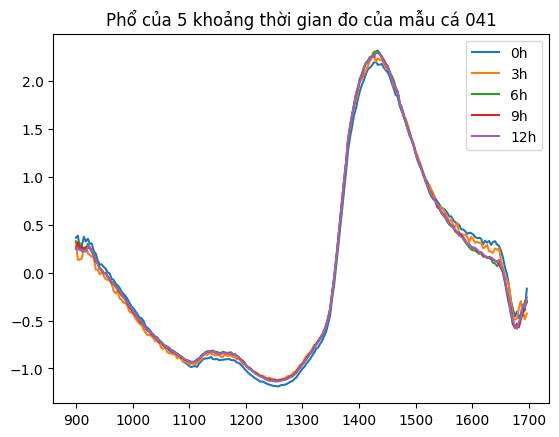

In [21]:
wl = np.arange(900, 1700, 800/228)
one_sample = df.iloc[0:5, -228:]
for i in range(5):
    plt.plot(wl, one_sample.iloc[i,:], label=f'{i*3}h')
plt.legend()
plt.title('Phổ của 5 khoảng thời gian đo của mẫu cá 041')

In [22]:
sample = []
for type in df['Loại cá'].unique():
    c = df[df['Loại cá'].str.contains(type)].reset_index()
    sample.append(c.iloc[0,-228:].to_numpy())
    
X_sample = pd.DataFrame(sample)
wl = np.arange(900, 1700, 800/228)

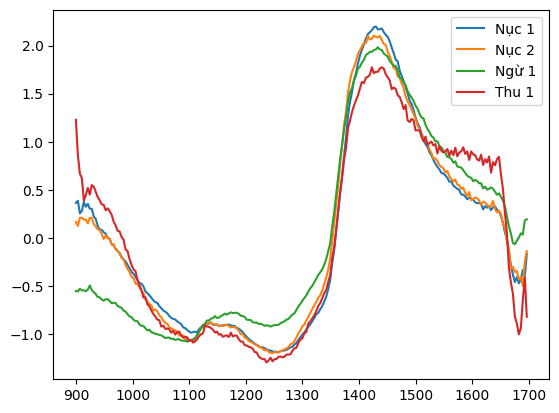

In [23]:
for i, type_fiss in enumerate(df['Loại cá'].unique()):
    plt.plot(wl, (X_sample).iloc[i,:], label=type_fiss)
plt.legend()

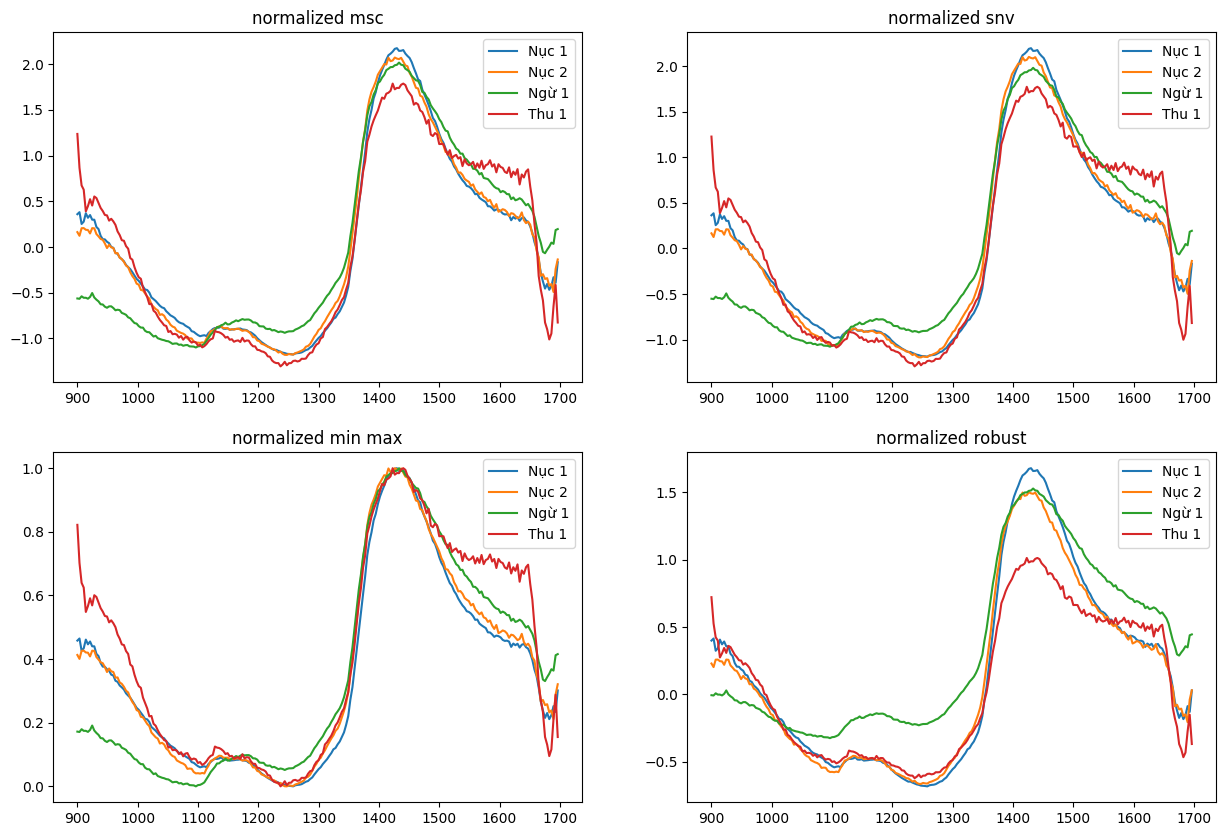

In [24]:
X_Robust = my_RobustScaler(X_sample)
X_minmax = my_MinMaxScaler(X_sample)
X_msc = msc(X_sample)
X_snv = snv(X_sample)

my_list = [X_msc, X_snv, X_minmax, X_Robust]
name = ['normalized msc', 'normalized snv', 'normalized min max', 'normalized robust']

fig, ax = plt.subplots(2, 2, figsize=(15,10))

i2 = 0
for a in range(2):
    for b in range(2):
        for i, type_fiss in enumerate(df['Loại cá'].unique()):
            ax[a][b].plot(wl, (my_list[i2]).iloc[i,:], label=type_fiss)
            ax[a][b].set_title(name[i2])
        ax[a][b].legend()
        i2 += 1

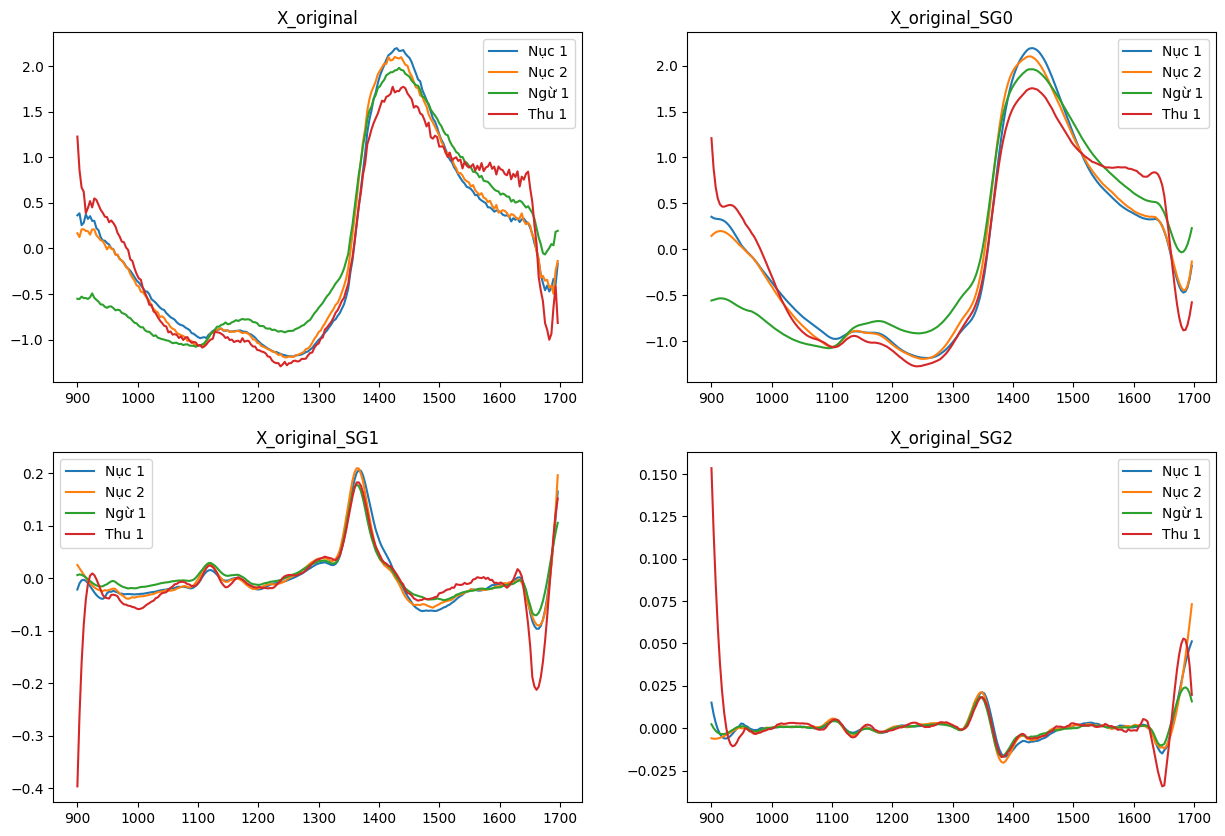

In [25]:
def plot_spectral(data, name_data):
    fig, ax = plt.subplots(2, 2, figsize=(15,10))

    X_SG0 = pd.DataFrame(my_SG(data, deriv=0))
    X_SG1 = pd.DataFrame(my_SG(data, deriv=1))
    X_SG2 = pd.DataFrame(my_SG(data, deriv=2))

    my_list = [data, X_SG0, X_SG1, X_SG2 ]
    name = [f'X_{name_data}', f'X_{name_data}_SG0', f'X_{name_data}_SG1', f'X_{name_data}_SG2']

    wl = np.arange(900, 1700, 800/228)
    i2 =0
    for a in range(2):
        for b in range(2):
            for i, type_fiss in enumerate(df['Loại cá'].unique()):
                ax[a][b].plot(wl, (my_list[i2]).iloc[i,:], label=type_fiss)
                ax[a][b].set_title(name[i2])
            ax[a][b].legend()
            i2 += 1
        
plot_spectral(X_sample, 'original')

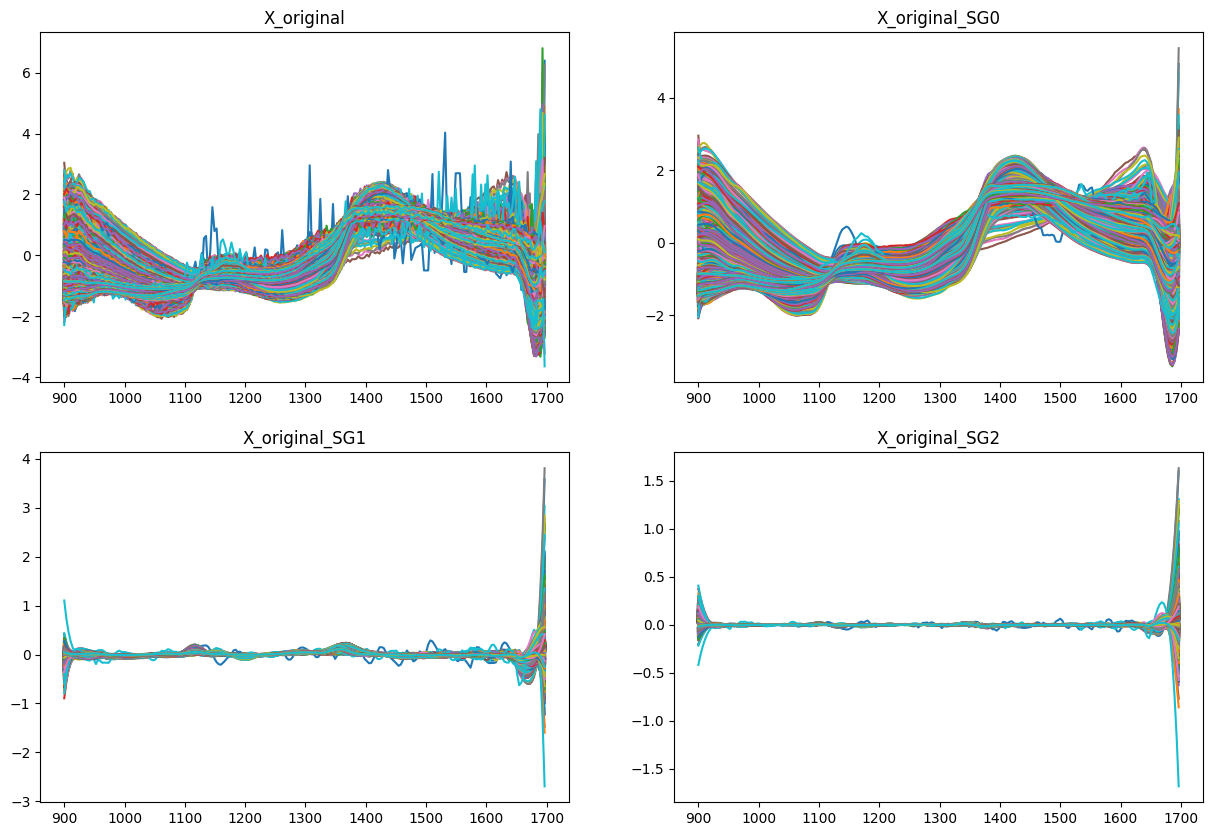

In [26]:
def plot_spectral2(data, name_data):
    fig, ax = plt.subplots(2, 2, figsize=(15,10))

    X_SG0 = my_SG(data, deriv=0)
    X_SG1 = my_SG(data, deriv=1)
    X_SG2 = my_SG(data, deriv=2)

    my_list = [data, X_SG0, X_SG1, X_SG2 ]
    name = [f'X_{name_data}', f'X_{name_data}_SG0', f'X_{name_data}_SG1', f'X_{name_data}_SG2']

    wl = np.arange(900, 1700, 800/228)
    i2 =0
    for a in range(2):
        for b in range(2):
            for i in range(data.shape[0]):
                ax[a][b].plot(wl, (my_list[i2]).iloc[i,:], label=type_fiss)
                ax[a][b].set_title(name[i2])
            i2 += 1
        
plot_spectral2(X_TRAIN, 'original')

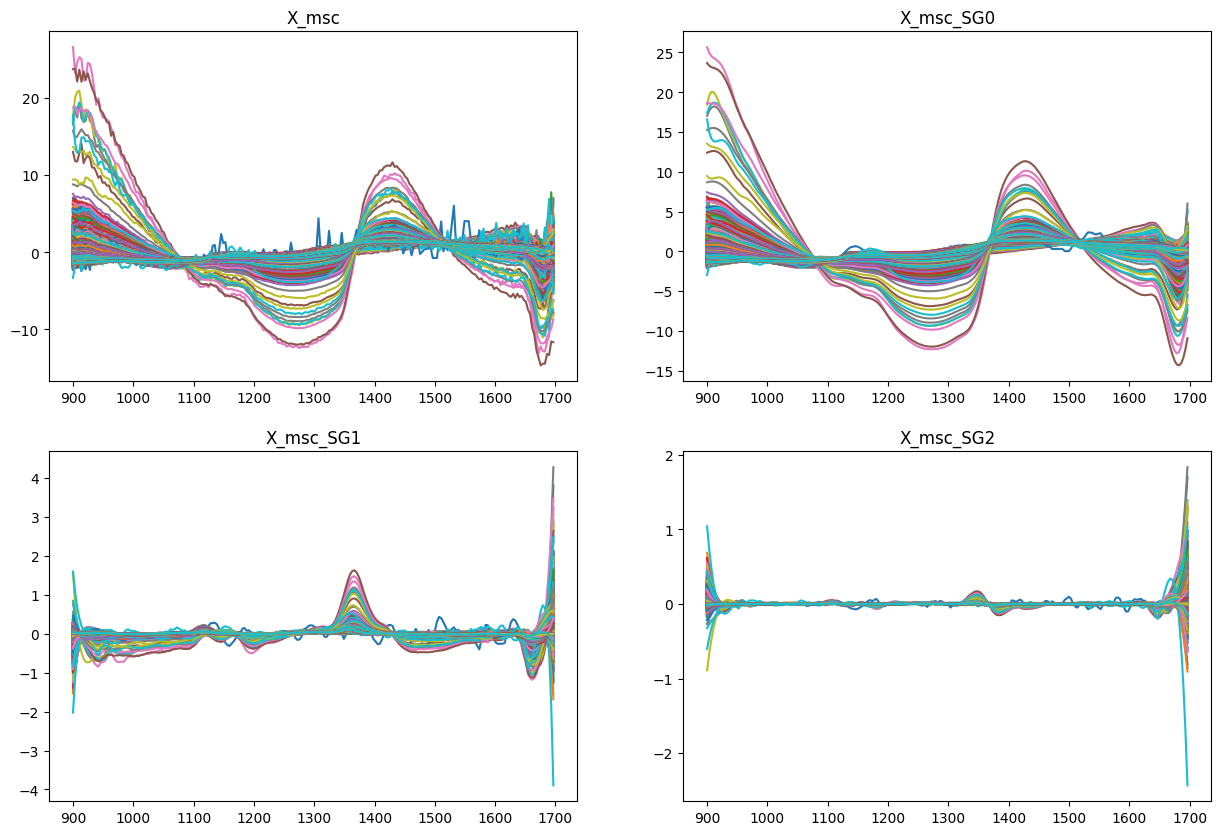

In [27]:
plot_spectral2(msc(X_TRAIN), 'msc')

In [28]:
sample_train = []
sample_test = []
for type in train_data['Loại cá'].unique():
    c = train_data[train_data['Loại cá'].str.contains(type)].reset_index()
    sample_train.append(c.iloc[0,-228:].to_numpy())

for type in test_data['Loại cá'].unique():
    c = test_data[test_data['Loại cá'].str.contains(type)].reset_index()
    sample_test.append(c.iloc[0,-228:].to_numpy())
    
X_sample_train = pd.DataFrame(sample_train)
X_sample_test = pd.DataFrame(sample_test)

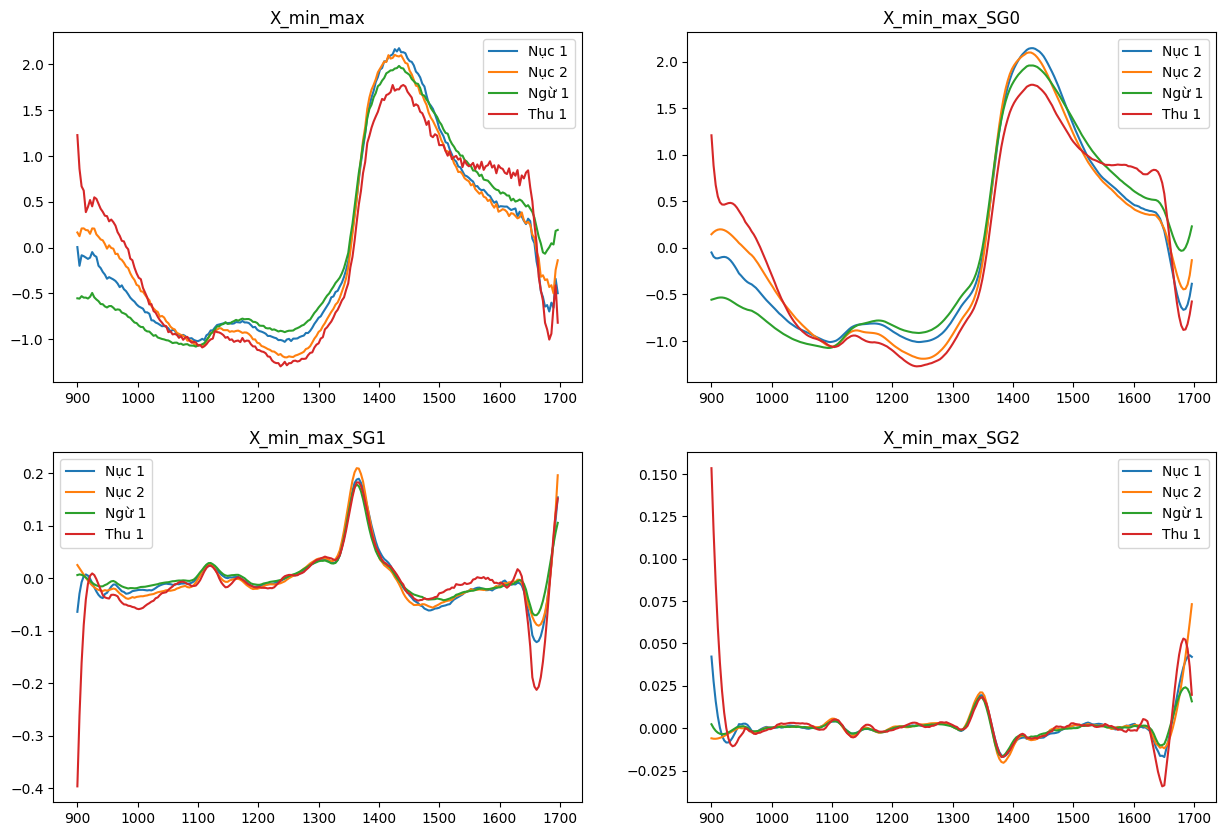

In [29]:
plot_spectral(X_sample_train, 'min_max')

# best K 

In [30]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def get_optimal_wavelength(X, y, top_n_features=10):
    best_features = SelectKBest(score_func=f_classif, k=top_n_features)
    fit = best_features.fit(X, y)

    return list(fit.get_feature_names_out())

In [31]:
np.where(df['Urea'] >= LOD_URE, 1, 0).shape

(8450,)

In [32]:
df.iloc[:,-N_WAVELENGTH].shape

(8450,)

In [33]:
n = get_optimal_wavelength(df.iloc[:,-N_WAVELENGTH:], np.where(df['Urea'] >= LOD_URE, 1, 0))
n

['148', '149', '150', '177', '233', '234', '235', '236', '237', '238']

In [34]:
print(get_optimal_wavelength(X_TRAIN_SMOTE, Y_TRAIN_SMOTE))
print(get_optimal_wavelength(X_TRAIN, Y_TRAIN))
print(get_optimal_wavelength(X_TEST, Y_TEST))

['147', '148', '149', '150', '151', '177', '178', '235', '236', '237']
['147', '148', '149', '150', '151', '210', '225', '235', '236', '237']
['148', '149', '150', '178', '180', '234', '235', '236', '237', '238']


In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import kennard_stone as ks
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate

X_train, X_test, y_train, y_test = ks.train_test_split(df.iloc[:, -N_WAVELENGTH:], np.where(df['Urea'] >= LOD_URE, 1, 0), test_size = 0.2)

In [38]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_score(y_test, y_pred_knn)

0.9159763313609467

In [ ]:

# clf_rf_4 = RandomForestClassifier() 
# rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
# rfecv = rfecv.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)

# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', X_TRAIN_SMOTE.columns[rfecv.support_])

In [ ]:
# from sklearn.feature_selection import RFECV

# # The "accuracy" scoring is proportional to the number of correct classifications
# clf_rf_4 = RandomForestClassifier() 
# rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
# rfecv = rfecv.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)

# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', X_TRAIN_SMOTE.columns[rfecv.support_])

# KNN

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


In [40]:
acc_max = 0
optimal_n_wl = 0
optimal_n_neighbors = 0
n_optimal_wavelength = []
for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(df.iloc[:,-N_WAVELENGTH:], np.where(df['Urea'] >= LOD_URE, 1, 0), n_wl)
    n_wavelength = [int(i) - (df.shape[1]-N_WAVELENGTH) for i in n_wavelength]
    for k in range(3,22,2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
        y_pred_knn = knn.predict(X_TEST.iloc[:,n_wavelength])
        acc = accuracy_score(Y_TEST, y_pred_knn)
        
        if acc > acc_max:
            acc_max = acc
            optimal_n_wl = n_wl
            optimal_n_neighbors = k
            n_optimal_wavelength = n_wavelength
print(acc_max, optimal_n_wl, optimal_n_neighbors)

0.6571428571428571 90 15


In [35]:
# n_optimal_wavelength = [int(i) - (df.shape[1]-N_WAVELENGTH) for i in get_optimal_wavelength(X_TRAIN_SMOTE, Y_TRAIN_SMOTE, optimal_n_wl)]
# knn = KNeighborsClassifier(n_neighbors=optimal_k)
# knn.fit(X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength], Y_TRAIN_SMOTE)
# y_pred_knn = knn.predict(X_TEST.iloc[:,n_optimal_wavelength])
# accuracy_score(Y_TEST, y_pred_knn)

In [69]:
# acc_knn = []

# xticks_knn = np.arange(3, 30, 2)
# for k in xticks_knn:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
#     y_pred_knn = knn.predict(X_TEST)
#     acc_knn.append(accuracy_score(Y_TEST, y_pred_knn))
    
# idx_knn = np.argmax(acc_knn)
# optimal_n_neighbors = idx_knn*2 + 3

# plt.plot(xticks_knn, acc_knn, '-v', color='blue', mfc='blue')
# plt.plot(xticks_knn[idx_knn], acc_knn[idx_knn], 'P', ms=10, mfc='red')
# plt.xlabel("n neighbors")
# plt.ylabel("Accuracy")
# plt.title(f'Optimal n neighbors for KNN = {optimal_n_neighbors}')

In [44]:
def my_preprocess_data(X_train, y_train, X_test, y_test, feature='sg0', normalization = 'msc'):
    X_train_prep = X_train
    X_test_prep = X_test
    if normalization == 'msc':
        X_train_prep = msc(X_train)
        X_test_prep = msc(X_test)
    elif normalization == 'snv':
        X_train_prep = snv(X_train)
        X_test_prep = snv(X_test)
    elif normalization == 'minmax':
        X_train_prep = my_MinMaxScaler(X_train)
        X_test_prep = my_MinMaxScaler(X_test)
    elif normalization == 'robust':
        X_train_prep = my_RobustScaler(X_train)
        X_test_prep = my_RobustScaler(X_test)
        
    if feature == 'sg0':
        X_train_prep = my_SG(X_train_prep, 0)
        X_test_prep = my_SG(X_test_prep, 0)
    elif feature == 'sg1':
        X_train_prep = my_SG(X_train_prep, 1)
        X_test_prep = my_SG(X_test_prep, 1)
    elif feature == 'sg2':
        X_train_prep = my_SG(X_train_prep, 2)
        X_test_prep = my_SG(X_test_prep, 2)
    elif feature == 'sg1 + sg2':
        X_train_SG1 = my_SG(X_train_prep, 1)
        X_train_SG2 = my_SG(X_train_prep, 2)
        X_train_prep = np.hstack([X_train_SG1, X_train_SG2])
        
        X_test_SG1 = my_SG(X_test_prep, 1)
        X_test_SG2 = my_SG(X_test_prep, 2)
        X_test_prep = np.hstack([X_test_SG1, X_test_SG2])
        
    return X_train_prep, y_train, X_test_prep, y_test

In [42]:
print(f'Parameter for KNN, k = {optimal_n_neighbors}')

Parameter for KNN, k = 15


In [43]:
def my_KNN(X_train, y_train, X_test, y_test, optimal_n_neighbors=3):

    knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    return acc


In [45]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength]
        X_test = X_TEST.iloc[:,n_optimal_wavelength]
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train, Y_TRAIN_SMOTE, X_test, 
                                                              Y_TEST,feature=feature, normalization=normal)

        print(my_KNN(X_train, y_train, X_test, y_test, optimal_n_neighbors))


64.762
64.762
62.5
65.595
63.214000000000006
62.26199999999999
62.5
61.845000000000006
58.452000000000005
59.524
58.69
58.571
61.845000000000006
61.607
62.143
62.143


# Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [47]:
best_criterion = ''
best_acc = 0
best_max_depth = 0
best_min_samples_leaf = 0
for criterion in ['gini', 'entropy']:
    for depth in range(3, 20):
        for samples_leaf in range(3, 20):
            dtc = DecisionTreeClassifier(criterion=criterion, max_depth=depth, min_samples_leaf=samples_leaf)
            dtc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
            y_pred_dtc = dtc.predict(X_TEST)
            acc = accuracy_score(Y_TEST, y_pred_dtc)
            
            if acc > best_acc:
                best_acc = acc
                best_criterion = criterion
                best_max_depth = depth
                best_min_samples_leaf = samples_leaf
                
print(f'best accuracy: {best_acc} with criterion: {best_criterion} max_depth: {best_max_depth} best_min_samples_leaf: {best_min_samples_leaf}')

best accuracy: 0.6404761904761904 with criterion: entropy max_depth: 5 best_min_samples_leaf: 3


In [48]:
best_acc2 = 0
n_optimal_wavelength_dt = []
for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(df.iloc[:,-N_WAVELENGTH:], np.where(df['Urea'] >= LOD_URE, 1, 0), n_wl)
    n_wavelength = [int(i) - (df.shape[1]-N_WAVELENGTH) for i in n_wavelength]

    dtc = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
    dtc.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
    y_pred_dtc = dtc.predict(X_TEST.iloc[:,n_wavelength])
    acc = accuracy_score(Y_TEST, y_pred_dtc)
    
    if acc > best_acc2:
        best_acc2 = acc
        n_optimal_wavelength_dt = n_wavelength
        
print(best_acc2, len(n_optimal_wavelength_dt))

0.6482142857142857 50


=> Sử dụng criterion='gini', max_depth = 5, min_samples_leaf = 3 sẽ là tối ưu nhất

In [49]:
def my_DecisionTree(X_train, y_train, X_test, y_test):
     
    dtc = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth, 
                                 min_samples_leaf=best_min_samples_leaf)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100
    
    return acc

In [50]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_dt]
        X_test = X_TEST.iloc[:,n_optimal_wavelength_dt]
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train, Y_TRAIN_SMOTE, X_test, 
                                                              Y_TEST,feature=feature, normalization=normal)
        print(my_DecisionTree(X_train, y_train, X_test, y_test))

64.167
64.524
62.202
63.63100000000001
60.297999999999995
58.928999999999995
63.74999999999999
59.88099999999999
61.964
62.678999999999995
64.286
58.392999999999994
58.69
60.476
64.286
58.452000000000005


# Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
best_acc_rfc = 0
best_n_estimators = 0

for n_tree in range(100,301,10):
    rfc = RandomForestClassifier(n_estimators=n_tree, criterion=best_criterion, max_depth=best_max_depth,
                                    min_samples_leaf=best_min_samples_leaf)
    rfc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
    y_pred = rfc.predict(X_TEST)
    acc_rfc = accuracy_score(Y_TEST, y_pred)
    if acc_rfc > best_acc_rfc:
        best_acc_rfc = acc_rfc
        best_n_estimators = n_tree
    print(n_tree, acc_rfc)

100 0.6464285714285715
110 0.6625
120 0.6571428571428571
130 0.6601190476190476
140 0.6571428571428571
150 0.6654761904761904
160 0.6613095238095238
170 0.6535714285714286
180 0.6642857142857143
190 0.6589285714285714
200 0.6529761904761905
210 0.6660714285714285
220 0.6488095238095238
230 0.6541666666666667
240 0.6607142857142857
250 0.6571428571428571
260 0.6601190476190476
270 0.656547619047619
280 0.6553571428571429
290 0.6613095238095238
300 0.655952380952381


In [53]:
print(best_acc_rfc, best_n_estimators)

0.6660714285714285 210


In [70]:
best_acc_rfc2 = 0
n_optimal_wavelength_rf = []

for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(df.iloc[:,-N_WAVELENGTH:], np.where(df['Urea'] >= LOD_URE, 1, 0), n_wl)
    n_wavelength = [int(i) - (df.shape[1]-N_WAVELENGTH) for i in n_wavelength]
    
    rfc = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, max_depth=best_max_depth,
                                    min_samples_leaf=best_min_samples_leaf)
    rfc.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
    y_pred = rfc.predict(X_TEST.iloc[:,n_wavelength])
    acc_rfc2 = accuracy_score(Y_TEST, y_pred)
    print(acc_rfc2, len(n_wavelength))
    if acc_rfc2 > best_acc_rfc2:
        best_acc_rfc2 = acc_rfc2
        n_optimal_wavelength_rf = n_wavelength
        
print(best_acc_rfc2, len(n_optimal_wavelength_rf))
    

0.6333333333333333 10
0.6672619047619047 30
0.6785714285714286 50
0.669047619047619 70
0.6791666666666667 90
0.6648809523809524 110
0.6672619047619047 130
0.6630952380952381 150
0.656547619047619 170
0.6625 190
0.6791666666666667 90


In [78]:
def my_RandomForest(X_train, y_train, X_test, y_test):
        
    rfc = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, max_depth=best_max_depth,
                                    min_samples_leaf=best_min_samples_leaf)
    rfc.fit(X_train, y_train.ravel())

    y_pred = rfc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    return acc

In [80]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_rf]
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_rf]
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, Y_TRAIN_SMOTE, X_test_, 
                                                              Y_TEST,feature=feature, normalization=normal)
        print(my_RandomForest(X_train, y_train, X_test, y_test))

0.6886904761904762
0.6892857142857143
0.6375
0.675
0.6857142857142857
0.6886904761904762
0.6654761904761904
0.6523809523809524
0.6601190476190476
0.6589285714285714
0.6607142857142857
0.6583333333333333
0.6821428571428572
0.6833333333333333
0.6654761904761904
0.6494047619047619


In [81]:
# all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
# all_normalization = ['msc', 'snv', 'minmax', 'robust']
# n_wl = 40
# with open(f'accuracy_{n_wl}WL_BALANCE.csv', 'w', newline='',encoding='utf-8-sig') as f:
#     headers = ['KNN', 'Decision Tree', 'Random Forest']
#     csv.DictWriter(f, delimiter=',', lineterminator='\n', fieldnames=headers).writeheader()
#     writer = csv.writer(f)
#     for feature in all_feature_exaction:
#         for normal in all_normalization:
#             acc = []
#             n_optimal_wavelength = [int(i) - (df.shape[1]-N_WAVELENGTH) for i in get_optimal_wavelength(X_TRAIN_SMOTE, Y_TRAIN_SMOTE, n_wl)]
#             X_train, y_train, X_test, y_test = my_preprocess_data(X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength], Y_TRAIN_SMOTE, 
#                                                                   X_TEST.iloc[:,n_optimal_wavelength], Y_TEST,
#                                                                   feature=feature, normalization=normal)

#             acc.append(my_KNN(X_train, y_train, X_test, y_test))
#             acc.append(my_DecisionTree(X_train, y_train, X_test, y_test))
#             acc.append(my_RandomForest(X_train, y_train, X_test, y_test))
#             print(acc)
#             writer.writerow(acc)

# SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
best_acc_svm = 0
best_c = 0
best_kernel = ''

for kernel in ['linear', 'poly', 'rbf']:
    for c in range(-3,4):
        svc = SVC(kernel=kernel, C=10**int(c)) 
        svc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
        y_pred = svc.predict(X_TEST)
        acc = accuracy_score(Y_TEST, y_pred)
        
        if acc > best_acc_svm:
            best_acc_svm = acc
            best_c = 10**int(c)
            best_kernel = kernel
        

In [154]:
print(f'kernel: {best_kernel}, C: {best_c} => accuracy: {best_acc_svm}')

kernel: rbf, C: 1000 => accuracy: 0.7285714285714285


In [108]:
best_acc_svm = 0
n_optimal_wavelength_svm = []

for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(df.iloc[:,-N_WAVELENGTH:], np.where(df['Urea'] >= LOD_URE, 1, 0), n_wl)
    n_wavelength = [int(i) - (df.shape[1]-N_WAVELENGTH) for i in n_wavelength]
    
    svc = SVC(kernel=best_kernel, C=best_c) 
    svc.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
    y_pred = svc.predict(X_TEST.iloc[:,n_wavelength])
    acc_svm = accuracy_score(Y_TEST, y_pred)
    
    print(acc_svm, len(n_wavelength))
    if acc_svm > best_acc_svm:
        best_acc_svm = acc_svm
        n_optimal_wavelength_svm = n_wavelength
        
print(best_acc_svm, len(n_optimal_wavelength_svm))

0.6261904761904762 10
0.6791666666666667 30
0.6726190476190477 50
0.6803571428571429 70
0.7107142857142857 90
0.7226190476190476 110
0.7178571428571429 130
0.7226190476190476 150
0.725 170
0.7285714285714285 190
0.7285714285714285 190


In [121]:
        
print(best_acc_svm, len(n_optimal_wavelength_svm))

0.7285714285714285 190


In [123]:

def my_SVM(X_train, y_train, X_test, y_test):
    
    # default SVM (rbf kernel)
    svc = SVC(kernel=best_kernel, C=best_c) 
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    return acc

In [124]:
# Sử dụng tất cả các đặc trưng
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

for feature in all_feature_exaction:
    for normal in all_normalization:

        X_train_ = X_TRAIN_SMOTE
        X_test_ = X_TEST
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, Y_TRAIN_SMOTE, X_test_, 
                                                              Y_TEST,feature=feature, normalization=normal)
        print(my_SVM(X_train, y_train, X_test, y_test))

73.452
74.464
73.69
72.381
69.583
67.679
69.048
68.571
68.155
69.167
68.81
68.81
69.405
67.619
68.452
68.214


In [125]:
# Sử dụng 190 đặc trưng
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_svm]
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_svm]
        
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, Y_TRAIN_SMOTE, X_test_, 
                                                              Y_TEST,feature=feature, normalization=normal)
        print(my_SVM(X_train, y_train, X_test, y_test))

72.857
72.798
72.024
70.417
69.286
68.452
68.452
68.155
68.631
67.262
68.571
68.69
68.69
68.452
68.333
68.095


Sử dụng tất cả các đặc trưng cho kết quả tốt nhất (mô hình SVC)

# CNN

In [126]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, Activation, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [144]:
from keras.utils.np_utils import to_categorical
y_train_smote_encode = to_categorical(Y_TRAIN_SMOTE, num_classes = 2)
y_test_encode = to_categorical(Y_TEST, num_classes = 2)

In [142]:
def my_CNN(X_train_val, y_train_val, X_test, y_test):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size = 0.25, random_state=42)
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=0.000001, verbose = 1)
    early_stop = EarlyStopping(patience=50)
    
    model = Sequential([
        Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Conv1D(filters=32, kernel_size=5, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Conv1D(filters=32, kernel_size=5, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Conv1D(filters=64, kernel_size=7, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dropout(0.01),
        Dense(2,activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    his = model.fit(X_train, y_train, batch_size=64, epochs=1000, validation_data=(X_val, y_val), callbacks=[early_stop, learning_rate_reduction])
    
    evaluate_train = model.evaluate(X_train, y_train)
    evaluate_val = model.evaluate(X_val, y_val)
    evaluate_test = model.evaluate(X_test, y_test)
    
    return his, evaluate_train[1], evaluate_val[1], evaluate_test[1]

In [146]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']
HISTORY = []

for normal in all_normalization:
    X_train_ = X_TRAIN_SMOTE
    X_test_ = X_TEST
    
    X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, y_train_smote_encode, X_test_, 
                                                            y_test_encode,feature='sg0', normalization=normal)
    HISTORY.append(my_CNN(X_train, y_train, X_test, y_test))

Epoch 1/1000
130/130 [==============================] - 2s 13ms/step - loss: 0.6929 - accuracy: 0.5094 - val_loss: 0.6971 - val_accuracy: 0.4998 - lr: 5.0000e-04
Epoch 2/1000
130/130 [==============================] - 2s 12ms/step - loss: 0.6901 - accuracy: 0.5309 - val_loss: 0.6922 - val_accuracy: 0.4980 - lr: 5.0000e-04
Epoch 3/1000
130/130 [==============================] - 2s 12ms/step - loss: 0.6839 - accuracy: 0.5570 - val_loss: 0.6795 - val_accuracy: 0.5561 - lr: 5.0000e-04
Epoch 4/1000
130/130 [==============================] - 2s 12ms/step - loss: 0.6770 - accuracy: 0.5580 - val_loss: 0.6728 - val_accuracy: 0.5630 - lr: 5.0000e-04
Epoch 5/1000
130/130 [==============================] - 1s 11ms/step - loss: 0.6694 - accuracy: 0.5743 - val_loss: 0.6725 - val_accuracy: 0.5655 - lr: 5.0000e-04
Epoch 6/1000
130/130 [==============================] - 1s 11ms/step - loss: 0.6661 - accuracy: 0.5825 - val_loss: 0.6653 - val_accuracy: 0.5906 - lr: 5.0000e-04
Epoch 7/1000
130/130 [======

In [147]:
for i in HISTORY:
    print([np.round(x,5)*100 for x in i[1:]])

[99.831, 96.91499999999999, 61.25000000000001]
[99.625, 96.552, 59.46399999999999]
[98.41499999999999, 94.846, 58.274]
[99.274, 95.426, 60.714]


In [145]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']
HISTORY = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE
        X_test_ = X_TEST
        
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, y_train_smote_encode, X_test_, 
                                                              y_test_encode,feature=feature, normalization=normal)
        HISTORY.append(my_CNN(X_train, y_train, X_test, y_test))

Epoch 1/1000
130/130 [==============================] - 3s 18ms/step - loss: 0.6922 - accuracy: 0.5141 - val_loss: 0.6905 - val_accuracy: 0.5405 - lr: 5.0000e-04
Epoch 2/1000
130/130 [==============================] - 2s 17ms/step - loss: 0.6895 - accuracy: 0.5345 - val_loss: 0.6864 - val_accuracy: 0.5350 - lr: 5.0000e-04
Epoch 3/1000
130/130 [==============================] - 2s 17ms/step - loss: 0.6839 - accuracy: 0.5491 - val_loss: 0.6847 - val_accuracy: 0.5387 - lr: 5.0000e-04
Epoch 4/1000
130/130 [==============================] - 2s 17ms/step - loss: 0.6778 - accuracy: 0.5606 - val_loss: 0.6719 - val_accuracy: 0.5688 - lr: 5.0000e-04
Epoch 5/1000
130/130 [==============================] - 2s 17ms/step - loss: 0.6709 - accuracy: 0.5714 - val_loss: 0.6656 - val_accuracy: 0.5612 - lr: 5.0000e-04
Epoch 6/1000
130/130 [==============================] - 2s 17ms/step - loss: 0.6679 - accuracy: 0.5734 - val_loss: 0.6736 - val_accuracy: 0.5626 - lr: 5.0000e-04
Epoch 7/1000
130/130 [======

KeyboardInterrupt: 

In [148]:
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN_SMOTE, y_train_smote_encode, stratify=y_train_smote_encode, test_size = 0.25, random_state=42)

In [153]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=0.000001, verbose = 1)
early_stop = EarlyStopping(patience=50)

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)),
    MaxPool1D(pool_size=2, strides=2),
    Dropout(0.01),
    
    Conv1D(filters=64, kernel_size=7, activation='relu'),
    MaxPool1D(pool_size=2, strides=2),
    Dropout(0.01),
    
    Conv1D(filters=128, kernel_size=11, activation='relu'),
    MaxPool1D(pool_size=2, strides=2),
    Dropout(0.01),
    
    # Conv1D(filters=256, kernel_size=17, activation='relu'),
    # MaxPool1D(pool_size=2, strides=2),
    # Dropout(0.01),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.01),
    Dense(2,activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
his = model.fit(X_train, y_train, batch_size=64, epochs=1000, validation_data=(X_val, y_val), callbacks=[early_stop, learning_rate_reduction])

evaluate_train = model.evaluate(X_train, y_train)
evaluate_val = model.evaluate(X_val, y_val)
evaluate_test = model.evaluate(X_TEST, y_test_encode)

Epoch 1/1000
130/130 [==============================] - 4s 25ms/step - loss: 0.6906 - accuracy: 0.5275 - val_loss: 0.6822 - val_accuracy: 0.5742 - lr: 5.0000e-04
Epoch 2/1000
130/130 [==============================] - 3s 23ms/step - loss: 0.6769 - accuracy: 0.5713 - val_loss: 0.6732 - val_accuracy: 0.5760 - lr: 5.0000e-04
Epoch 3/1000
130/130 [==============================] - 3s 25ms/step - loss: 0.6623 - accuracy: 0.5940 - val_loss: 0.6638 - val_accuracy: 0.5771 - lr: 5.0000e-04
Epoch 4/1000
130/130 [==============================] - 3s 23ms/step - loss: 0.6496 - accuracy: 0.6060 - val_loss: 0.6540 - val_accuracy: 0.5938 - lr: 5.0000e-04
Epoch 5/1000
130/130 [==============================] - 3s 24ms/step - loss: 0.6367 - accuracy: 0.6165 - val_loss: 0.6439 - val_accuracy: 0.6174 - lr: 5.0000e-04
Epoch 6/1000
130/130 [==============================] - 3s 23ms/step - loss: 0.6251 - accuracy: 0.6335 - val_loss: 0.6296 - val_accuracy: 0.6374 - lr: 5.0000e-04
Epoch 7/1000
130/130 [======